In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import hashlib
import json
from itertools import combinations

# 1. Overview
Distributed constraint satisfaction is about how independent agents can come up with a solution to a problem. We don't have to worry about individual preferences, but a central processor can't be used. 

It doesn't matter which solution we come up with, so long as the constraints are satisfied. In the next chapter we ask how independent agents can also work optimise a global objective function.

## 1.1 Defining distributed constraint satisfaction problems
A distributed constraint problem is defined by:

1. Variables
2. Domains for each variable
3. Constraints on what all the variables can be

The goal of the solver is to find a combination of values such that the contraints are satisfied, or else determine that no such combination exists.

In this chapter for simplicity the constraints are restricted to be binary (i.e., only between two variables), but more complicated constraints are possible. 

**Example problem:**
Consider a network of cell towers. Each tower needs to use a different frequency to those nearby in order to avoid interference. We want to choose those frequencies without using a central computer. This is essentially a graph coloring problem - each tower can be thought of as a node, with an edge between nodes if the towers are in close proximity, and where the frequencies are the colors.

Here is a diagram representing this kind of problem:

In [2]:
def plot_nodes_and_edges(nodes,edges,pos=None,padding=1):
    plt.figure(figsize=(6, 6))
    G = nx.Graph()
    for node, domain in nodes.items():
        G.add_node(node, domain=domain)
    G.add_edges_from(edges)
    if(pos is None):
        pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='white',edgecolors='black', linewidths=2)
    nx.draw_networkx_edges(G, pos)
    labels = {node: f"{node}\n\n{G.nodes[node]['domain']}" for node in G.nodes()}
    label_pos = {node: (x+0.01, y - 0.15) for (node, (x, y)) in pos.items()}
    nx.draw_networkx_labels(G, label_pos, labels, font_size=14)   
    x_values, y_values = zip(*pos.values())
    plt.xlim(min(x_values) - padding, max(x_values) + padding)
    plt.ylim(min(y_values) - padding, max(y_values) + padding)
    plt.show()
    return pos # return the position so that we can reuse it for the next plot.

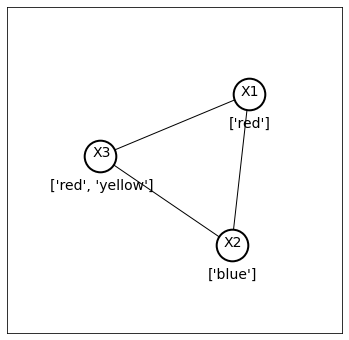

In [3]:
# example, just to show the plot. In this case there is just 1 solution 
_ = plot_nodes_and_edges({"X1":["red"],"X2":["blue"],"X3":["red","yellow"]},[("X1","X2"),("X2","X3"),("X1","X3")])

## 1.2 Domain pruning algorithms
Domain pruning algorithms find a solution by gradually removing values from each node. Two approaches are considered here. 
### The filtering algorithm
The filtering algorithm is very simple. Each node first communicates it's domain to it's neighbours, then removes values from it's own domain that cannot be consistent with the other values. If it does this, then it's new values are then sent as well.

Note: we assume that messages from a neighbour may arrive after some delay, but not in a different order. So Sam might send me a message before Bob, but with a delay I instead get Bob's first. But Bob's second message will not arrive before his first. This implementation below adds some randomness to when messages are received to fit this assumption. 

In [4]:
class FilteringAlgorithmNode:
    
    def __init__ (self,name,domain):
        self.name = name
        self.domain = domain
        self.neighbours = []
        self.processed_messages = {} # dictionary mapping the neighbour's name (unique) to their messages.
        self.new_messages = {} # incoming messages, which might only be read after a delay.
        self.need_rerun = False # do you need to rerun revise_domain?
    
    def add_neighbour(self,neighbour):
        self.neighbours.append(neighbour)
        self.processed_messages[neighbour.name]=[]
        self.new_messages[neighbour.name]=[]
    
    def update_inbox(self):
        not_empty = False
        for neighbour in self.neighbours:
            inbox = self.new_messages[neighbour.name]
            if len(inbox)>0:
                not_empty = True
                if(np.random.rand()<0.1): # random chance the message has come in
                    message = inbox.pop(0)
                    self.processed_messages[neighbour.name].append(message)
                    print(self.name,"read from",neighbour.name,"that",message)
                    self.need_rerun = True
            
        return not_empty
    
    def send_domain_to_neighbours(self):
        for neighbour in self.neighbours:
            neighbour.new_messages[self.name].append(self.domain.copy())
    
    def revise_domain(self):
        if self.need_rerun:
            self.need_rerun = False
            domain_copy = self.domain.copy()
            for my_value_option in domain_copy: # need to copy to avoid removing while looping. 
                for other_node in self.neighbours:
                    if(len(self.processed_messages[other_node.name])>0):
                        other_domain = self.processed_messages[other_node.name][-1] # latest message
                        if all([my_value_option==other_value for other_value in other_domain]):
                            # this value is not possible, remove from domain.
                            self.domain.remove(my_value_option)
                            break

            if len(self.domain)<len(domain_copy): #  did you change your domain?
                self.send_domain_to_neighbours()
                print(self.name,"revised their domain from",domain_copy,"to",self.domain)
                changed_domain = True
            else:
                changed_domain = False
        else:
            changed_domain = False
        
        empty_set_generated = len(self.domain)==0
        return changed_domain, empty_set_generated

In [5]:
def run_filtering_algorithm(node_dict,edge_dict):
    node_positions = plot_nodes_and_edges(node_dict,edge_dict)
    
    nodes = {key:FilteringAlgorithmNode(key,domain.copy()) for key,domain in node_dict.items()}
    for (node1,node2) in edge_dict:
        nodes[node1].add_neighbour(nodes[node2])
        nodes[node2].add_neighbour(nodes[node1])
    
    for node in nodes.values(): # initially every node sends its domain. 
        node.send_domain_to_neighbours()
    
    while True:
        any_domain_update = False # did at least one node update?
        any_empty_set_generated = False # did any node terminate with an empty domain?
        any_inbox = False # did at least 1 node get a new message?
        for node in nodes.values():
            inbox_not_empty = node.update_inbox()
            changed_domain, empty_set_generated = node.revise_domain()
            if(changed_domain):
                any_domain_update = True
            if(inbox_not_empty):
                any_inbox = True
            if(empty_set_generated):
                any_empty_set_generated = True
        
        if(any_domain_update):
            node_dict_revised = dict(zip(nodes.keys(),[node.domain for node in nodes.values()]))
            _ = plot_nodes_and_edges(node_dict_revised,edge_dict,node_positions)
        
        if any_empty_set_generated:
            print("a node has an empty domain, terminating")
            break
        
        if not any_inbox and not any_domain_update:
            print("inboxes are empty and no nodes have updated their domains, terminating")
            break

To show this method in action consider the following solvable problem:

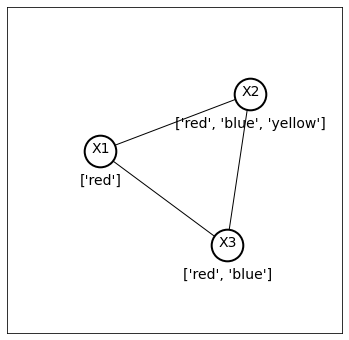

X1 read from X2 that ['red', 'blue', 'yellow']
X2 read from X3 that ['red', 'blue']
X3 read from X2 that ['red', 'blue', 'yellow']
X3 read from X1 that ['red']
X3 revised their domain from ['red', 'blue'] to ['blue']


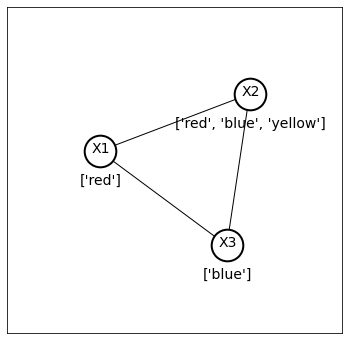

X1 read from X3 that ['red', 'blue']
X2 read from X1 that ['red']
X2 revised their domain from ['red', 'blue', 'yellow'] to ['blue', 'yellow']


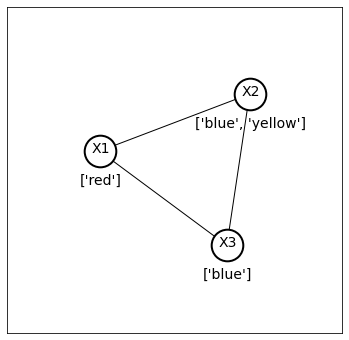

X1 read from X3 that ['blue']
X1 read from X2 that ['blue', 'yellow']
X2 read from X3 that ['blue']
X2 revised their domain from ['blue', 'yellow'] to ['yellow']


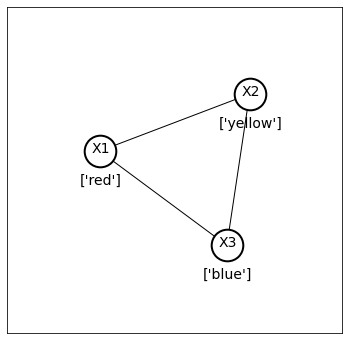

X1 read from X2 that ['yellow']
X3 read from X2 that ['blue', 'yellow']
X3 read from X2 that ['yellow']
inboxes are empty and no nodes have updated their domains, terminating


In [6]:
run_filtering_algorithm(
    {
        "X1":["red"],
        "X2":["red","blue","yellow"],
        "X3":["red","blue"]
    },
    [("X1","X2"),("X1","X3"),("X2","X3")]
)

And if a solution is not possible, this algorithm can find that out too:

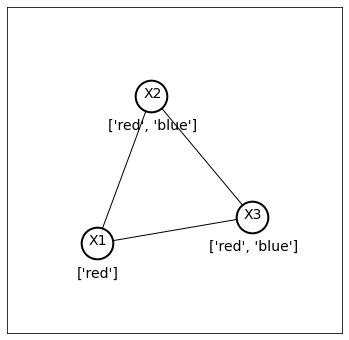

X1 read from X3 that ['red', 'blue']
X2 read from X3 that ['red', 'blue']
X1 read from X2 that ['red', 'blue']
X2 read from X1 that ['red']
X2 revised their domain from ['red', 'blue'] to ['blue']


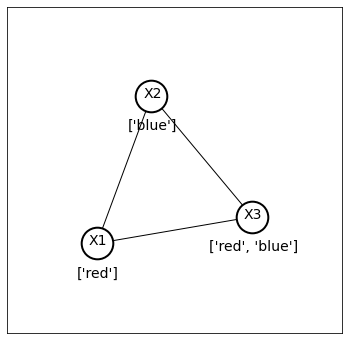

X3 read from X1 that ['red']
X3 revised their domain from ['red', 'blue'] to ['blue']


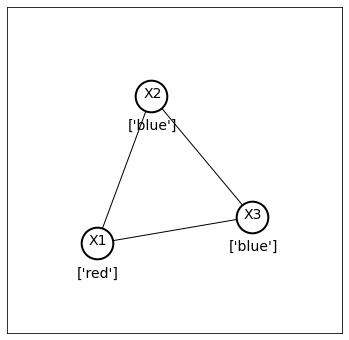

X1 read from X2 that ['blue']
X1 read from X3 that ['blue']
X2 read from X3 that ['blue']
X2 revised their domain from ['blue'] to []


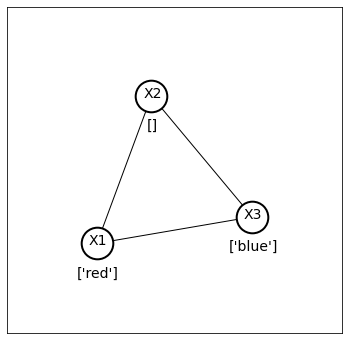

a node has an empty domain, terminating


In [7]:
run_filtering_algorithm(
    {
        "X1":["red"],
        "X2":["red","blue"],
        "X3":["red","blue"]
    },
    [("X1","X2"),("X1","X3"),("X2","X3")]
)

But not always! Sometimes even though a problem has no answer, this algorithm can't find that out. In the below case there are only 2 colors and 3 nodes, so the problem can't be solved. But no node can eliminate any variable by the above method.

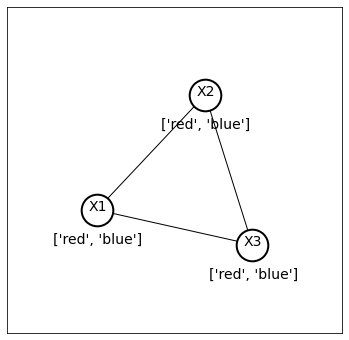

X1 read from X3 that ['red', 'blue']
X2 read from X1 that ['red', 'blue']
X1 read from X2 that ['red', 'blue']
X2 read from X3 that ['red', 'blue']
X3 read from X1 that ['red', 'blue']
X3 read from X2 that ['red', 'blue']
inboxes are empty and no nodes have updated their domains, terminating


In [8]:
run_filtering_algorithm(
    {
        "X1":["red","blue"],
        "X2":["red","blue"],
        "X3":["red","blue"]
    },
    [("X1","X2"),("X1","X3"),("X2","X3")]
)

And the same is true even of problems which are solvable. Here there are 3 colors and 3 nodes, but the algorithm will never converge on a particular setting. 

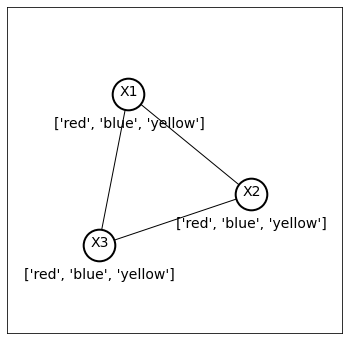

X2 read from X1 that ['red', 'blue', 'yellow']
X3 read from X2 that ['red', 'blue', 'yellow']
X2 read from X3 that ['red', 'blue', 'yellow']
X1 read from X2 that ['red', 'blue', 'yellow']
X3 read from X1 that ['red', 'blue', 'yellow']
X1 read from X3 that ['red', 'blue', 'yellow']
inboxes are empty and no nodes have updated their domains, terminating


In [9]:
run_filtering_algorithm(
    {
        "X1":["red","blue","yellow"],
        "X2":["red","blue","yellow"],
        "X3":["red","blue","yellow"]
    },
    [("X1","X2"),("X1","X3"),("X2","X3")]
)

### The hyper-resolution algorithm
The filtering algorithm is based on propositional logic, in particular the unit-resolution rule, which can be explained by a simple example:

(note: $\lor$ is logical-or, and $\land$ is logical-and):

$X_1 = \text{red}$ <br>
$\neg(X_1 = \text{red} \land X_2 = \text{red})$ <br>
means <br>
$\neg X_2 = \text{red}$

We can extend this to what is called the hyper-resolution rule. Hyper-resolution notes that when a variable can belong to a number of options, and each option has a possible problem, then all those problems cannot be true at the same time. E.g., see:

$X_1 = \text{red} \lor X_1 = \text{blue}$ <br>
$\neg(X_1 = \text{red} \land X_2 = \text{red})$ <br>
$\neg(X_1 = \text{blue} \land X_3 = \text{blue})$ <br>
means <br>
$\neg X_2 = \text{red} \land X_3 = \text{blue}$

Unit resolution is then just Hyper-resolution in a simple case. The hyper resolution algorithm works in a similar way to the filtering algorithm, but instead nodes generate new constraints at each step and communicate those to their neighbours. Each of these constraints can be called a "Nogood".

Here is the logic for making a new nogood from a combination of nogoods and the variable domain:

In [10]:
def generate_new_nogood(variable_name,variable_domain,nogood_selection):
    """
        Generates a new nogood, using every rule in nogood_selection using hyper-resolution.
        Each nogood must have a value for variable_name.
        All values in domain need to be mentioned at least once. 
        The final nogood cannot assign a variable two values.
    """
    domain_coverage = dict(zip(variable_domain,[False for _ in range(len(variable_domain))]))
    new_nogood = {}
    for nogood in nogood_selection:
        if not variable_name in nogood:
            return None # this variable not in input nogood - cant substitute
        else:
            domain_value_being_replaced = nogood[variable_name]
            domain_coverage[domain_value_being_replaced] = True
            for other_variable,other_value in nogood.items():
                if not other_variable==variable_name:
                    if other_variable in new_nogood: # we have added already!
                        if not other_value==new_nogood[other_variable]:
                            return None # a variable cannot have 2 different values!
                    else:
                        new_nogood[other_variable]=other_value
    if all(domain_coverage.values()):
        return new_nogood
    else:
        return None

Testing

In [11]:
# test 1: needs to fail, as we don't do a replacement for if X1=blue.
print("test 1:",
      generate_new_nogood(
          "X1", # variable
          ["red","blue"], # domain
          [
              {"X1":"red","X2":"blue"} # current nogood
          ]
      )
)

test 1: None


In [12]:
# test 2: needs to succeed, and say X2 can't be blue while X3 is yellow. 
print("test 2:",
      generate_new_nogood(
          "X1",
          ["red","blue"],
          [
              {"X1":"red","X2":"blue"},
              {"X1":"blue","X3":"yellow"}
          ]
      )
)

test 2: {'X2': 'blue', 'X3': 'yellow'}


In [13]:
# test 3: needs to succeed, and say X2 can't be blue while X3 is yellow. 
# Here the blue and red conditions impose the same restriction on X2
print("test 3:",
      generate_new_nogood(
          "X1",
          ["red","blue","green"],
          [
              {"X1":"red","X2":"blue"},
              {"X1":"blue","X2":"blue"},
              {"X1":"green","X3":"yellow"}
          ]
      )
)

test 3: {'X2': 'blue', 'X3': 'yellow'}


In [14]:
# test 4: needs to succeed, and say X3 can't be blue. 
print("test 4:",
      generate_new_nogood(
          "X1",
          ["red","blue"],
          [
              {"X1":"red","X3":"blue"},
              {"X1":"blue","X3":"blue"},
          ]
      )
)

test 4: {'X3': 'blue'}


In [15]:
# test 5: needs to succeed, but produce the empty set.  
print("test 5:",
      generate_new_nogood(
          "X3",
          ["red","blue"],
          [
              {"X3":"red"},
              {"X3":"blue"},
          ]
      )
)

test 5: {}


Now, the main class. Here we keep track of whether we already have a nogood with a hash.

In [16]:
def dictionary_hash(d):
    # given a dictionary, give a hash that is the same regardless of the dictionary order.
    sorted_items = tuple(sorted(d.items()))
    json_str = json.dumps(sorted_items)
    hash_object = hashlib.sha256(json_str.encode())
    return hash_object.hexdigest()

In [17]:
class HyperResolutionAlgorithmNode:
    
    def __init__ (self,name,domain):
        self.name = name
        self.domain = domain
        self.neighbours = []
        self.nogoods = [] # instead of other node domains we store a list of nogoods
        self.nogood_hashes = [] # to keep the nogoods unique lets store a hash of each
        self.new_messages = {}
        self.need_rerun = True
        
    def add_neighbour(self,neighbour):
        self.neighbours.append(neighbour)
        self.new_messages[neighbour.name]=[]
    
    def update_inbox(self):
        not_empty = False
        for neighbour in self.neighbours:
            inbox = self.new_messages[neighbour.name]
            if len(inbox)>0:
                not_empty = True
                if(np.random.rand()<0.1): # random chance the message has come in
                    message = inbox.pop(0) # message is a list of nogoods
                    for nogood in message:
                        nogood_hash = dictionary_hash(nogood)
                        if(not nogood_hash in self.nogood_hashes):
                            self.nogoods.append(nogood)
                            self.nogood_hashes.append(nogood_hash)
                            print(self.name,"read from",neighbour.name,"nogood",nogood)
                            self.need_rerun = True
        return not_empty
    
    def send_nogoods_to_neighbours(self):
        for neighbour in self.neighbours:
            neighbour.new_messages[self.name].append(self.nogoods.copy())
    
    def revise_nogoods(self):
        if(self.need_rerun):
            self.need_rerun = False
            indexes = list(range(len(self.nogoods)))
            all_combinations = []
            for r in range(1, len(indexes) + 1):
                all_combinations.extend(combinations(indexes, r))
            all_combinations = [list(combo) for combo in all_combinations]
            
            if (len(all_combinations)>1000000):
                print(self.name)
                for i in range(len(self.nogoods)):
                    print(self.nogoods[i])
                raise ValueError("too many combinations!")

            empty_set_generated = False
            any_new = False
            for comb in all_combinations:
                new_nogood = generate_new_nogood(self.name,self.domain,[self.nogoods[index] for index in comb])
                if not new_nogood is None:
                    if len(new_nogood)==0:
                        print("node",self.name,"generated empty set")
                        empty_set_generated = True
                        break
                    else:
                        nogood_hash = dictionary_hash(new_nogood)
                        if not nogood_hash in self.nogood_hashes:
                            print("node",self.name,"generated new nogood:",new_nogood)
                            self.nogoods.append(new_nogood)
                            self.nogood_hashes.append(nogood_hash)
                            any_new = True
                            self.need_rerun = True

            if(any_new):
                self.send_nogoods_to_neighbours() # update others!

            domain_revised = False
            for nogood in self.nogoods:
                if(len(nogood)==1):
                    if self.name in nogood:
                        value_to_remove_from_domain = nogood[self.name]
                        if value_to_remove_from_domain in self.domain:
                            self.domain.remove(value_to_remove_from_domain)
                            domain_revised = True

        else:
            domain_revised = False
            empty_set_generated = False
            
        done = len(self.domain)==1
        return (domain_revised, empty_set_generated,done)            

In [18]:
def run_hyper_resolution_algorithm(node_dict,edge_dict):
    node_positions = plot_nodes_and_edges(node_dict,edge_dict)
    
    nodes = {key:HyperResolutionAlgorithmNode(key,domain.copy()) for key,domain in node_dict.items()}
    for (node1,node2) in edge_dict:
        nodes[node1].add_neighbour(nodes[node2])
        nodes[node2].add_neighbour(nodes[node1])
        common_domain = list(set(nodes[node1].domain) & set(nodes[node2].domain))
        for value in common_domain:
            nogood = {nodes[node1].name:value,nodes[node2].name:value}
            nogood_hash = dictionary_hash(nogood)
            nodes[node1].nogoods.append(nogood)
            nodes[node2].nogoods.append(nogood)
            nodes[node1].nogood_hashes.append(nogood_hash)
            nodes[node2].nogood_hashes.append(nogood_hash)            
    
    for node in nodes.values(): # initially every node sends it's domain. 
        node.send_nogoods_to_neighbours()
    
    while True:
        any_empty_set_found = False
        any_domain_updated = False # did at least one node rule out a value?
        any_inbox = False # did at least 1 node get a new message?
        all_completed = True
        for node in nodes.values():
            inbox_not_empty = node.update_inbox()
            if(inbox_not_empty):
                any_inbox = True
                
            (domain_revised, empty_set_generated,completed) = node.revise_nogoods()
            if domain_revised:
                any_domain_updated = True
            
            if empty_set_generated:
                any_empty_set_found = True
            
            if completed==False:
                all_completed = False
        
        if(any_domain_updated):
            node_dict_revised = dict(zip(nodes.keys(),[node.domain for node in nodes.values()]))
            _ = plot_nodes_and_edges(node_dict_revised,edge_dict,node_positions)
            
        if any_empty_set_found:
            print("the empty set was found, no solution")
            break
        
        if not any_inbox and not any_domain_updated:
            print("inboxes are empty and no nodes have updated their domains, terminating")
            break
        
        if all_completed:
            print("all node values are assigned")
            break

And to test, here is a solvable problem again:
Note: might take a half a minute to run. Lots of combinations!

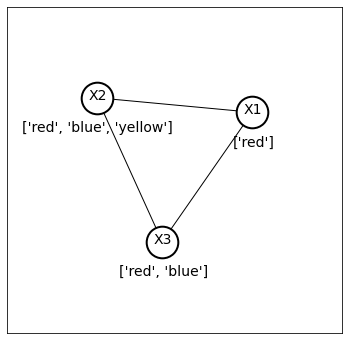

node X1 generated new nogood: {'X2': 'red'}
node X1 generated new nogood: {'X3': 'red'}
node X1 generated new nogood: {'X2': 'red', 'X3': 'red'}
node X3 generated new nogood: {'X1': 'red', 'X2': 'blue'}
X2 read from X1 nogood {'X1': 'red', 'X3': 'red'}
X3 read from X1 nogood {'X1': 'red', 'X2': 'red'}
X2 read from X1 nogood {'X2': 'red'}
X2 read from X1 nogood {'X3': 'red'}


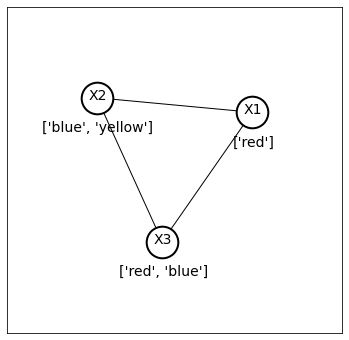

X1 read from X2 nogood {'X2': 'blue', 'X3': 'blue'}
X2 read from X3 nogood {'X1': 'red', 'X2': 'blue'}
X1 read from X3 nogood {'X1': 'red', 'X2': 'blue'}
node X1 generated new nogood: {'X2': 'blue'}
node X1 generated new nogood: {'X3': 'red', 'X2': 'blue'}
X3 read from X1 nogood {'X2': 'red'}
X3 read from X1 nogood {'X3': 'red'}
node X3 generated new nogood: {'X2': 'blue'}


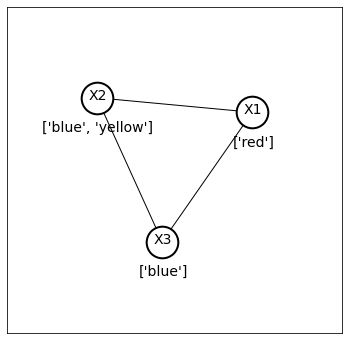

X3 read from X1 nogood {'X3': 'red', 'X2': 'blue'}
X2 read from X3 nogood {'X2': 'blue'}


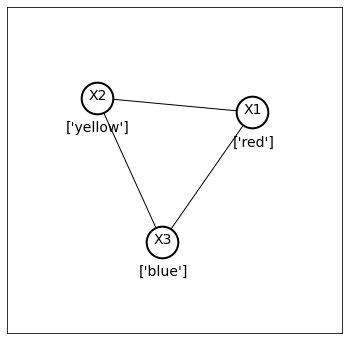

all node values are assigned


In [19]:
run_hyper_resolution_algorithm(
    {
        "X1":["red"],
        "X2":["red","blue","yellow"],
        "X3":["red","blue"]
    },
    [("X1","X2"),("X1","X3"),("X2","X3")]
)

And we can test agaim with an unsolvable problem:

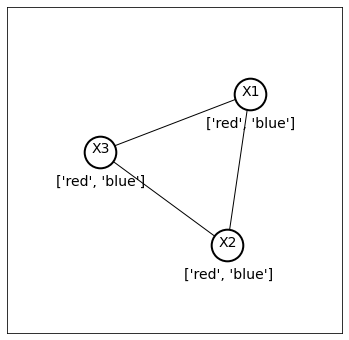

X1 read from X3 nogood {'X2': 'red', 'X3': 'red'}
X1 read from X3 nogood {'X2': 'blue', 'X3': 'blue'}
node X1 generated new nogood: {'X2': 'red', 'X3': 'blue'}
node X1 generated new nogood: {'X2': 'blue', 'X3': 'red'}
node X2 generated new nogood: {'X1': 'red', 'X3': 'blue'}
node X2 generated new nogood: {'X1': 'blue', 'X3': 'red'}
node X3 generated new nogood: {'X1': 'red', 'X2': 'blue'}
node X3 generated new nogood: {'X1': 'blue', 'X2': 'red'}
X2 read from X3 nogood {'X1': 'red', 'X3': 'red'}
X2 read from X3 nogood {'X1': 'blue', 'X3': 'blue'}
X3 read from X1 nogood {'X1': 'red', 'X2': 'red'}
X3 read from X1 nogood {'X1': 'blue', 'X2': 'blue'}
X2 read from X3 nogood {'X1': 'red', 'X2': 'blue'}
X2 read from X3 nogood {'X1': 'blue', 'X2': 'red'}
node X2 generated new nogood: {'X1': 'red'}
node X2 generated new nogood: {'X1': 'blue'}
X3 read from X1 nogood {'X2': 'red', 'X3': 'blue'}
X3 read from X1 nogood {'X2': 'blue', 'X3': 'red'}
node X3 generated new nogood: {'X2': 'red'}
node X3 g

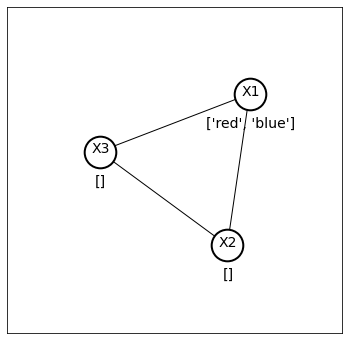

the empty set was found, no solution


In [20]:
run_hyper_resolution_algorithm(
    {
        "X1":["red","blue"],
        "X2":["red","blue"],
        "X3":["red","blue"]
    },
    [("X1","X2"),("X1","X3"),("X2","X3")]
)

In the case where there are multiple solutions, the program also halts:

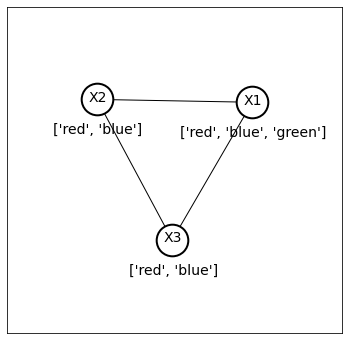

X1 read from X3 nogood {'X2': 'red', 'X3': 'red'}
X1 read from X3 nogood {'X2': 'blue', 'X3': 'blue'}
X2 read from X3 nogood {'X1': 'red', 'X3': 'red'}
X2 read from X3 nogood {'X1': 'blue', 'X3': 'blue'}
node X2 generated new nogood: {'X1': 'red', 'X3': 'blue'}
node X2 generated new nogood: {'X1': 'blue', 'X3': 'red'}
node X3 generated new nogood: {'X1': 'red', 'X2': 'blue'}
node X3 generated new nogood: {'X1': 'blue', 'X2': 'red'}
X2 read from X3 nogood {'X1': 'red', 'X2': 'blue'}
X2 read from X3 nogood {'X1': 'blue', 'X2': 'red'}
node X2 generated new nogood: {'X1': 'red'}
node X2 generated new nogood: {'X1': 'blue'}
X3 read from X2 nogood {'X1': 'red', 'X2': 'red'}
X3 read from X2 nogood {'X1': 'blue', 'X2': 'blue'}
X3 read from X2 nogood {'X1': 'red', 'X3': 'blue'}
X3 read from X2 nogood {'X1': 'blue', 'X3': 'red'}
node X3 generated new nogood: {'X1': 'red'}
node X3 generated new nogood: {'X1': 'blue'}
X1 read from X3 nogood {'X1': 'red', 'X2': 'blue'}
X1 read from X3 nogood {'X1':

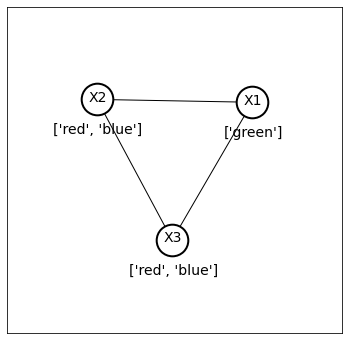

inboxes are empty and no nodes have updated their domains, terminating


In [21]:
run_hyper_resolution_algorithm(
    {
        "X1":["red","blue","green"],
        "X2":["red","blue"],
        "X3":["red","blue"]
    },
    [("X1","X2"),("X1","X3"),("X2","X3")]
)

Here we just need to choose a value for X2 or X3 and then proceed again:

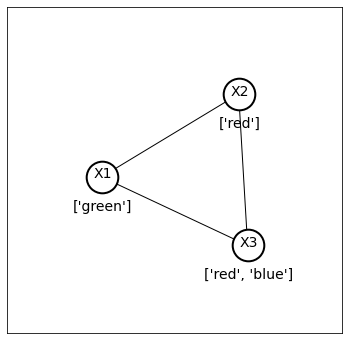

node X2 generated new nogood: {'X3': 'red'}
X1 read from X3 nogood {'X2': 'red', 'X3': 'red'}
X3 read from X2 nogood {'X3': 'red'}


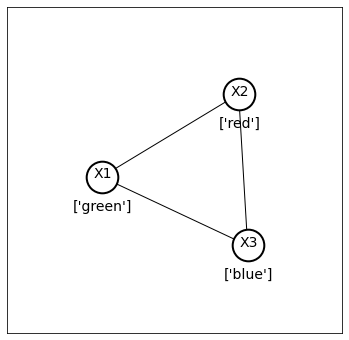

all node values are assigned


In [22]:
run_hyper_resolution_algorithm(
    {
        "X1":["green"],
        "X2":["red"],
        "X3":["red","blue"]
    },
    [("X1","X2"),("X1","X3"),("X2","X3")]
)

Unfortunately, while this method works it is very inefficient. The number of "nogoods" scales very quickly. And calculating a new nogood from the current ones is quite expensive (though, probably cheaper than my method here). In order to do better we might want to consider alternatives based on heuristics, which are covered in the next section. 